In [3]:
import cv2 
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

In [4]:
'''Function to plot a box based on the matrix given, as long as the first 8 values are the 8 corners'''
def plot(box, pointcolor = 'k', linecolor = 'k', degree1 = 30, degree2 = 45):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    ax.scatter3D(box[:, 0], box[: ,1], box[:, 2], c = pointcolor)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


    verts = [[box[0],box[1],box[2],box[3]], [box[4],box[5],box[6],box[7]], [box[0],box[1],box[5],box[4]], [box[3],box[2],box[6],box[7]]]
             #[box[1],box[2],box[6],box[5]], [box[1],box[2],box[5],box[7]]]

    # plot sides
    ax.add_collection3d(Poly3DCollection(verts, facecolors='w', linewidths=1, edgecolors=linecolor, alpha=.25))
    ax.view_init(degree1, degree2)
    
    
#Rotation
'''Rotation function to return Omega based on what degree was given'''
def rotation(x):
    return np.array([[np.cos(x * np.pi/180), 0, -np.sin(x * np.pi/180)], 
                   [0, 1, 0],
                   [np.sin(x * np.pi/180), 0 , np.cos(x * np.pi/180)]])


def homogenous(X):
    # print(X.shape[1])
    return np.vstack((X, np.ones([1,X.shape[1]])))

'''Pinhole camera funciton to find the projected values'''
def pinhole(W, Lambda, Omega, Tau):
    
    OmegaTau = np.hstack([Omega, Tau.T])
    
    X = Lambda@ OmegaTau @ W

    #divide by to the z values in order to make it 1
    X = X/X[2]

    X = X.T
    
    return X
    
'''Calculate the normalized coordinates'''
def findX_(Lambda, Omega, Tau, W):
    # print(Lambda.shape)
    # print(Omega.shape)
    # print(Tau.shape)
    # print(W.shape)
    OmegaTau = np.hstack([Omega,Tau.T])

    X =  Lambda @ OmegaTau @ W

    X = X/X[2]

    #equation 14.27
    X_ = np.linalg.inv(Lambda) @ X

    X_ = X_/X_[2]

    return X_

'''Consturct the systems of equations from equation 14.30'''
def constructA(W, X_):
    #make empty array to be able to populate
    #print(W.shape)
    A = np.zeros((W.shape[0]*2, 12))
    # print(A.shape)
    i = 0
    for w, x_ in zip(W, X_):
        # print("\nw: ",w)
        # print("x: ",x_)
        A[i] = np.array([w[0], w[1], w[2], 1, 0 ,0 ,0 ,0 , -w[0]*x_[0], -w[1]*x_[0], -w[2]*x_[0], -x_[0]])
        A[i+1] =  np.array([0, 0, 0 ,0 ,w[0], w[1], w[2], 1 , -w[0]*x_[1], -w[1]*x_[1], -w[2]*x_[1], -x_[1]])
        # print(A[i])
        # print(A[i+1])
        i += 2

    return A

''' Find the estimates of Omega and Tau'''
def findEstimate(A):

    U,L,V = np.linalg.svd(A)

    #set b hat equal to last column
    b_ = V.T[:,-1]

    Omega = np.array([[b_[0],b_[1],b_[2]],
                      [b_[4],b_[5],b_[6]],
                      [b_[8],b_[9],b_[10]]])

    Tau = np.array([b_[3], b_[7], b_[11]])

    #every fourth point is tau 
    U_, L_, V_ = np.linalg.svd(Omega)

    Omega_hat = -(U_@V_)


    Tau_hat = np.array([np.sum(Omega_hat)/np.sum(Omega)*Tau])

    # Tau_hat = Tau_hat *-1

    # Tau_hat = Tau_hat*10

    # return np.hstack([Omega_hat, Tau_hat.T])
    return Omega_hat, Tau_hat



### Camera calibration intrinsic parameters

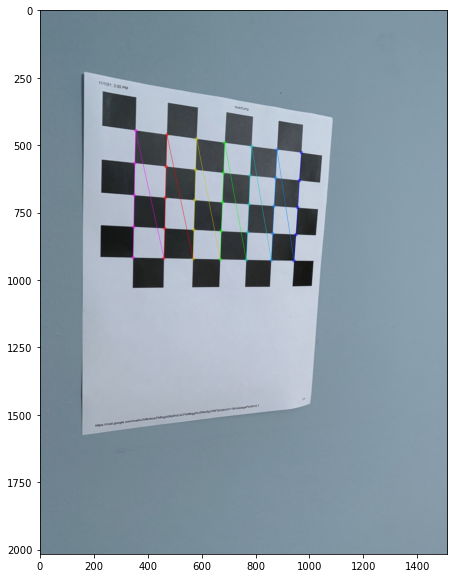

Camera matrix :
[[ 1586.08  0.00  772.12]
 [ 0.00  1592.48  1019.37]
 [ 0.00  0.00  1.00]]


In [5]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format},suppress=True)    

images = glob.glob('./images/*.jpg')

#number of vertical and horizontal
checkerboard = (5,7)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objpoints = []

imgpoints = []



objp = np.zeros((1, checkerboard[0] * checkerboard[1],3),np.float32)

objp[0,:,:2] = np.mgrid[0:checkerboard[0], 0:checkerboard[1]].T.reshape(-1, 2)

# print(objp.shape)


prev_img_shape = None

# print(len(images))

for fname in images:
    #read images
#     print(fname)
    img = cv2.imread(fname)
#     print(img.shape)
    #get grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    
    #function to find corners
    ret, corners = cv2.findChessboardCorners(gray, checkerboard) 
                                             # flags
                                             # cv2.CALIB_CB_ADAPTIVE_THRESH +
                                             # cv2.CALIB_CB_FAST_CHECK +
                                             # cv2.CALIB_CB_NORMALIZE_IMAGE)
#     print(corners)
    
    if ret == True:
        objpoints.append(objp)
#         print(len(objpoints))
        
        #get the best corners inside small neighborhood of the original location
        #critera = number of iterations
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,1), criteria)
        
        imgpoints.append(corners2)
        
        img = cv2.drawChessboardCorners(img, checkerboard, corners2, ret)
        
        
        
# type(img)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

# print(len(imgpoints))

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Camera matrix :")
print(mtx)

#     cv2.imshow('img', img)
#     cv2.waitKey(0)
    

### Getting 4 coordinates between 2 images

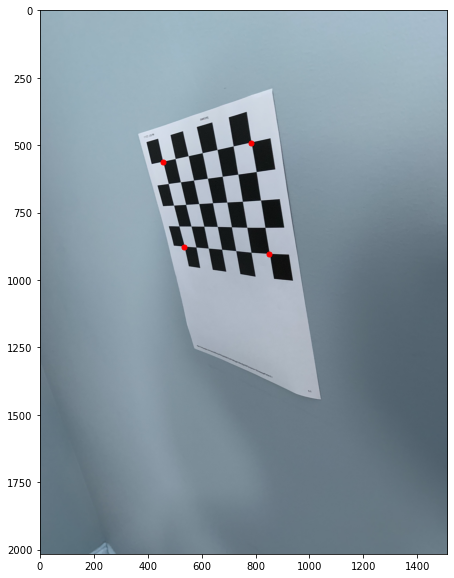

In [6]:
img1path = "./images/image2.jpg"
img2path = "./images/image7.jpg"

img1 = cv2.imread(img1path)
img2 = cv2.imread(img2path)

ret, imgcorners1 = cv2.findChessboardCorners(img1, checkerboard) 
ret, imgcorners2 = cv2.findChessboardCorners(img2, checkerboard) 

cornerindex = [0,4,30,34]

corner1 = imgcorners1[:,0][cornerindex]
corner2 = imgcorners2[:,0][cornerindex]

# print(corner1[:,0])
plt.figure(figsize=(10, 10))
plt.imshow(img1)
plt.scatter(corner1[:,0], corner1[:,1], marker = '.', color ='r', s = 100)
plt.show()

In [7]:
#Using the first image above

x = np.float32(corner1)
w = np.float32([[1000,1000],[1000,0],[0,1000],[0,0]])
    
print(x)
print(w)

[[ 783.66  490.38]
 [ 851.32  903.27]
 [ 456.26  561.52]
 [ 535.55  876.27]]
[[ 1000.00  1000.00]
 [ 1000.00  0.00]
 [ 0.00  1000.00]
 [ 0.00  0.00]]


### Homography function

In [8]:
#x and w are pairs of 4 points

def homography(x, w):    
#     print(x.shape)
#     print(w)

    A = np.zeros([x.shape[0]*2,9])
    
    i = 0
    for x,w in zip(x,w):
#         print(x)
#         print(w)
        A[i]   = np.array([0, 0, 0, -w[0], -w[1], -1, x[1]*w[0], x[1]*w[1], x[1]])  
        A[i+1] = np.array([w[0], w[1], 1, 0, 0, 0, -x[0]*w[0], -x[0]*w[1], -x[0]])
        i += 2
        
        
    U,L,VT = np.linalg.svd(A)

    Phi = VT.T[:,-1]
#     print(Phi)

#     print('\n')
    Phi = Phi.reshape(3,3)
#     print('Phi: \n',Phi)
    return Phi
            
    

In [9]:
Phi = homography(x,w)
print(Phi)  



[[ 0.00 -0.00  0.52]
 [-0.00 -0.00  0.85]
 [-0.00 -0.00  0.00]]


### Output to check comparison between CV2 and manual homography calculation

CV2 matrix: 
 [[ 4.40 -1.11 -1386.43]
 [ 0.32 -3.74  3102.34]
 [ 0.00 -0.00  1.00]]

Manual matrix: 
 [[ 4280.96 -1078.33 -1347737.01]
 [ 310.40 -3631.27  3015753.74]
 [ 0.98 -0.54  972.09]]

Manual, removed scale
: [[ 4.40 -1.11 -1386.43]
 [ 0.32 -3.74  3102.34]
 [ 0.00 -0.00  1.00]]


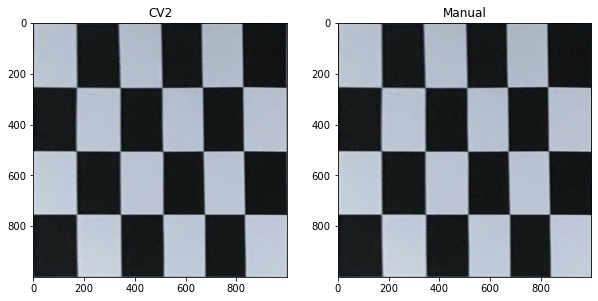

In [10]:
M = cv2.getPerspectiveTransform(x,w)
cvimg = cv2.warpPerspective(img1,M,(1000,1000))

Phi_inv = np.linalg.inv(Phi)

manimg = cv2.warpPerspective(img1,Phi_inv,(1000,1000))


fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].title.set_text('CV2')
axs[0].imshow(cvimg)
axs[1].title.set_text('Manual')
axs[1].imshow(manimg)
print("CV2 matrix: \n", M)
print("\nManual matrix: \n", Phi_inv)

print("\nManual, removed scale\n:",Phi_inv/Phi_inv[2][2])


# plt.imshow(dstImage)
plt.show()

### Extract Extrinsic parameters

In [15]:
def extrinsicparameters(Lambda, x, w):
    Phi = homography(x,w)
    Phi = np.linalg.inv(Phi)
    Phi = Phi/Phi[2][2]
    Phi_prime = np.linalg.inv(Lambda)@Phi
    
    print("Phi: \n", Phi)
    
    print("\nPhi_prime: \n", Phi_prime)
    
    U,L,VT = np.linalg.svd(Phi_prime[:,:2])
    
    Omega = np.zeros([3,3])
    print(U.shape)
    print(L.shape)
    print(VT.shape)
    
    D = np.array([[1,0],[0,1],[0,0]])
    
    Omega[:,:2] = U @ D @VT

    Omega[:,2] = np.cross(Omega[:,0], Omega[:,1])
    
    
    print('\nDeterminant:')
    print(np.linalg.det(Omega))

    #Check the determinant    
    if(np.linalg.det(Omega) <= 0):
        Omega[:,2] = -1 * Omega[:,2]
        
    print("\nOmega: \n", Omega)
        
    #Get the scaling factor
    scaling = (Phi_prime[:,:2].sum()/Omega[:,:2].sum())/6
    
    print("\nScaling: ", scaling) 
    
    Tau = np.array([Phi_prime[:, 2] / scaling])
    
    print("\nTau: ", Tau)
    
    return Omega, Tau

    

In [16]:
Lambda = mtx
Omega, Tau = extrinsicparameters(Lambda, x, w)

Phi: 
 [[ 4.40 -1.11 -1386.43]
 [ 0.32 -3.74  3102.34]
 [ 0.00 -0.00  1.00]]

Phi_prime: 
 [[ 0.00 -0.00 -1.36]
 [-0.00 -0.00  1.31]
 [ 0.00 -0.00  1.00]]
(3, 3)
(2,)
(2, 2)

Determinant:
1.0000000000000007

Omega: 
 [[ 0.89 -0.14  0.42]
 [-0.23 -0.96  0.16]
 [ 0.39 -0.24 -0.89]]

Scaling:  7.190679657835255e-05

Tau:  [[-18926.29  18190.25  13906.89]]


In [12]:
# manimg.shape
# print(Lambda.shape)
# print(Lambda.shape)
# print(Lambda.shape)
# print(Lambda.shape)
# test = pinhole(w, Lambda, Omega, Tau)
# plot(test)
